In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import yfinance as yf
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

In [ ]:
# Initialize Firebase
cred = credentials.Certificate('/content/drive/MyDrive/Predictions/financiaflutter-firebase-adminsdk-ajaw7-f515e50a59.json')
firebase_admin.initialize_app(cred)

In [ ]:
crypto_currency = 'ETH'
against_currency = 'USD'

start = dt.datetime(2016,1,1)
end = dt.datetime.now()

data = yf.download('ETH-USD', start=start, end=end)

[*********************100%***********************]  1 of 1 completed


Prepare Data

In [ ]:
print(data.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-11-09  308.644989  329.451996  307.056000  320.884003  320.884003   
2017-11-10  320.670990  324.717987  294.541992  299.252991  299.252991   
2017-11-11  298.585999  319.453003  298.191986  314.681000  314.681000   
2017-11-12  314.690002  319.153015  298.513000  307.907990  307.907990   
2017-11-13  307.024994  328.415009  307.024994  316.716003  316.716003   

                Volume  
Date                    
2017-11-09   893249984  
2017-11-10   885985984  
2017-11-11   842300992  
2017-11-12  1613479936  
2017-11-13  1041889984  


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scalar= MinMaxScaler(feature_range=(0,1))
scaled_data =scalar.fit_transform(data['Close'].values.reshape(-1,1))

In [ ]:
prediction_days = 60
future_day = 10

x_train, y_train=[], []

In [ ]:
for x in range(prediction_days, len(scaled_data)-future_day):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x+future_day, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Create Neural Network

In [ ]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
64/64 [==============================] - 15s 130ms/step - loss: 0.0157
Epoch 2/25
64/64 [==============================] - 6s 87ms/step - loss: 0.0060
Epoch 3/25
64/64 [==============================] - 7s 115ms/step - loss: 0.0061
Epoch 4/25
64/64 [==============================] - 5s 85ms/step - loss: 0.0052
Epoch 5/25
64/64 [==============================] - 6s 99ms/step - loss: 0.0055
Epoch 6/25
64/64 [==============================] - 7s 101ms/step - loss: 0.0045
Epoch 7/25
64/64 [==============================] - 6s 87ms/step - loss: 0.0047
Epoch 8/25
64/64 [==============================] - 7s 116ms/step - loss: 0.0047
Epoch 9/25
64/64 [==============================] - 6s 87ms/step - loss: 0.0049
Epoch 10/25
64/64 [==============================] - 7s 115ms/step - loss: 0.0046
Epoch 11/25
64/64 [==============================] - 6s 87ms/step - loss: 0.0046
Epoch 12/25
64/64 [==============================] - 7s 116ms/step - loss: 0.0047
Epoch 13/25
64/64 [===========

Testing the model

In [ ]:
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = yf.download('ETH-USD', start=test_start, end=test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

[*********************100%***********************]  1 of 1 completed


In [ ]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scalar.fit_transform(model_inputs)

In [ ]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
prediction_prices = model.predict(x_test)
prediction_prices = scalar.inverse_transform(prediction_prices)

41/41 [==============================] - 2s 26ms/step


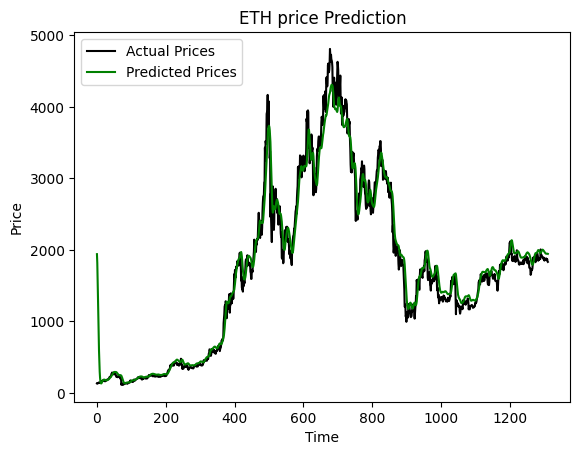

In [ ]:
plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title('ETH price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc = 'upper left')
plt.show()

# Predict next day

In [ ]:
real_data = [model_inputs[len(model_inputs)+1 - prediction_days:len(model_inputs) + 1, 0]]
real_data = np.array(real_data)


In [ ]:
real_data.shape

(1, 59)

In [ ]:
real_data = np.reshape(real_data, (real_data.shape[0],real_data.shape[1], 1))

In [ ]:
prediction = model.predict(real_data)
prediction = scalar.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 1s 1s/step
[[1940.2937]]


In [ ]:
# Save the prediction value to Firebase Firestore
db = firestore.client()
doc_ref = db.collection('predictioncrypto').document(crypto_currency)
doc_ref.set({
    'prediction': float(prediction[0][0])
})

update_time {
  seconds: 1691397161
  nanos: 317191000
}